<a href="https://colab.research.google.com/github/Eduardo-Velocci/Modelos-Arima-Para-Infla-o/blob/main/Modelos_Arima_Infla%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MODELOS ARIMA
Ciência de Dados Aplicada para Finanças e Economia - FGV

Eduardo de Almeida Velocci

Atividade proposta pelo professor João Ricardo Mendes Costa Filho

Curso de Econometria Aplicada

Motivação: Para onde vai a inflação? Nas economias que se encontram no pós-pandemia, a desorganização
das cadeias produtivas e as restrições de oferta encontraram a demanda (outrora reprimida) sem a mesma capacidade de atender às necessidades dos agentes, sem contar os efeitos das guerras e das políticas de combate à pandemia na China. Mesmo na ausência desses desafios todos, em economias como a brasileira o tema da inflação é de suma importância para o planejamento de empresas, famílias e governos. E o que deve acontecer com ela nos próximos 12 meses?


In [ ]:
install.packages(c("rbcb", "tidyverse", "fpp3", "urca", "ggplot2", "forecast"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘warp’, ‘BH’, ‘TTR’, ‘distributional’, ‘progressr’, ‘ggdist’, ‘slider’, ‘anytime’, ‘quadprog’, ‘quantmod’, ‘xts’, ‘fable’, ‘fabletools’, ‘feasts’, ‘tsibble’, ‘tsibbledata’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘zoo’, ‘RcppArmadillo’




In [ ]:
library(rbcb)
library(tidyverse)
library(fpp3)
library(urca)
library(ggplot2)
library(forecast)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr

── Attaching packages ──────────────────────────────────────────── fpp3 1.0.1 ──

✔ tsibble     1.1.6     ✔ feasts      0.4.1
✔ tsibbledata 0.4.1     ✔ fable       0.4.1

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks ba

In [ ]:
install.packages(c("tseries", "magrittr", "dplyr"))
library(tseries)
library(magrittr)
library(dplyr)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




Baixando as séries

In [ ]:
ipca_total <- get_series(433, start_date = '2004-01-01')
ipca_servicos <- get_series(10844, start_date = '2004-01-01')

Skipping download - using cached version

Skipping download - using cached version



In [ ]:
# Verificando e combinando os dados
print("Verificando estrutura dos dados...")
print("Estrutura IPCA Total:")
print(str(ipca_total))
print("Nomes das colunas IPCA Total:")
print(names(ipca_total))
print("Primeiras observações IPCA Total:")
print(head(ipca_total))

print("Estrutura IPCA Serviços:")
print(str(ipca_servicos))
print("Nomes das colunas IPCA Serviços:")
print(names(ipca_servicos))
print("Primeiras observações IPCA Serviços:")
print(head(ipca_servicos))

# Identificar os nomes corretos das colunas
nome_coluna_total <- names(ipca_total)[names(ipca_total) != "date"][1]
nome_coluna_servicos <- names(ipca_servicos)[names(ipca_servicos) != "date"][1]

print(paste("Nome da coluna de valores IPCA Total:", nome_coluna_total))
print(paste("Nome da coluna de valores IPCA Serviços:", nome_coluna_servicos))

# Combinando os dados de forma mais robusta
dados_combinados <- ipca_total %>%
  rename(ipca_total = !!nome_coluna_total) %>%
  full_join(
    ipca_servicos %>% rename(ipca_servicos = !!nome_coluna_servicos),
    by = "date"
  ) %>%
  filter(!is.na(ipca_total) & !is.na(ipca_servicos)) %>%
  arrange(date)

# Convertendo para formato tsibble (necessário para fpp3)
dados_inflacao <- dados_combinados %>%
  mutate(data = yearmonth(date)) %>%
  select(data, ipca_total, ipca_servicos) %>%
  as_tsibble(index = data)

print("Dados carregados com sucesso!")
print(paste("Período:", min(dados_inflacao$data), "a", max(dados_inflacao$data)))
print(paste("Observações:", nrow(dados_inflacao)))
print("Primeiras observações:")
print(head(dados_inflacao))

[1] "Verificando estrutura dos dados..."
[1] "Estrutura IPCA Total:"
tibble [258 × 2] (S3: tbl_df/tbl/data.frame)
 $ date: Date[1:258], format: "2004-01-01" "2004-02-01" ...
 $ 433 : num [1:258] 0.76 0.61 0.47 0.37 0.51 0.71 0.91 0.69 0.33 0.44 ...
NULL
[1] "Nomes das colunas IPCA Total:"
[1] "date" "433" 
[1] "Primeiras observações IPCA Total:"
# A tibble: 6 × 2
  date       `433`
  <date>     <dbl>
1 2004-01-01  0.76
2 2004-02-01  0.61
3 2004-03-01  0.47
4 2004-04-01  0.37
5 2004-05-01  0.51
6 2004-06-01  0.71
[1] "Estrutura IPCA Serviços:"
tibble [258 × 2] (S3: tbl_df/tbl/data.frame)
 $ date : Date[1:258], format: "2004-01-01" "2004-02-01" ...
 $ 10844: num [1:258] 0.62 1.9 0.49 0.3 0.3 0.26 0.49 0.59 0.23 0.33 ...
NULL
[1] "Nomes das colunas IPCA Serviços:"
[1] "date"  "10844"
[1] "Primeiras observações IPCA Serviços:"
# A tibble: 6 × 2
  date       `10844`
  <date>       <dbl>
1 2004-01-01    0.62
2 2004-02-01    1.9 
3 2004-03-01    0.49
4 2004-04-01    0.3 
5 2004-05-01    0.3 


#1) Gráficos mensais de Inflação total e de serviços

Gráfico da inflação total (IPCA)

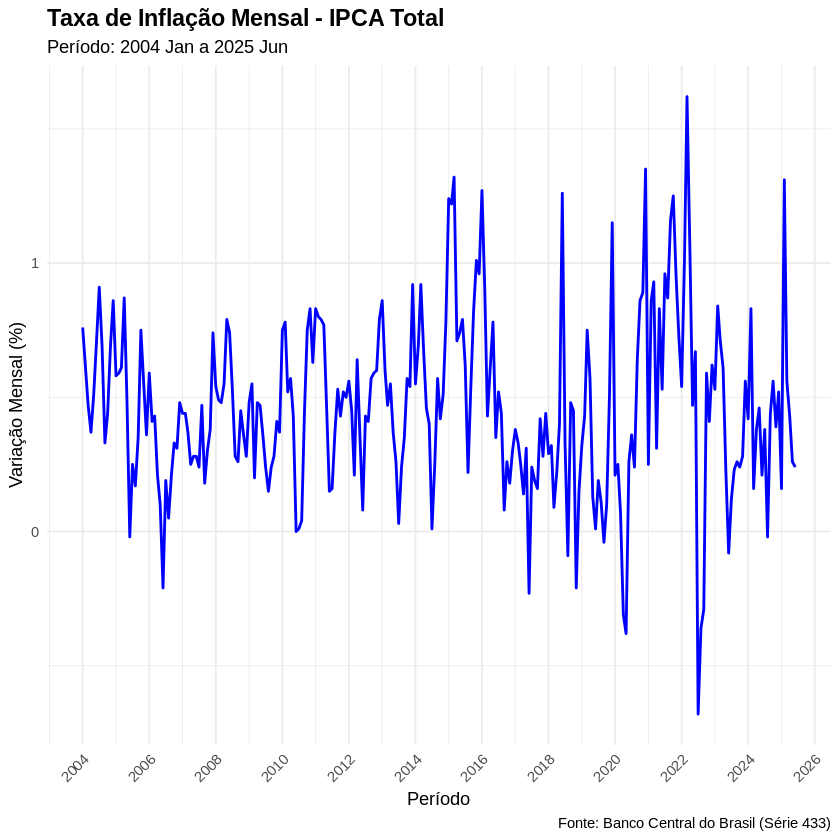

In [ ]:
grafico_ipca_total <- dados_inflacao %>%
  ggplot(aes(x = as.Date(data), y = ipca_total)) +
  geom_line(color = "blue", linewidth = 0.8) +
  labs(
    title = "Taxa de Inflação Mensal - IPCA Total",
    subtitle = paste("Período:", min(dados_inflacao$data), "a", max(dados_inflacao$data)),
    x = "Período",
    y = "Variação Mensal (%)",
    caption = "Fonte: Banco Central do Brasil (Série 433)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  scale_x_date(date_labels = "%Y", date_breaks = "2 years")

print(grafico_ipca_total)

Gráfico da inflação de serviços

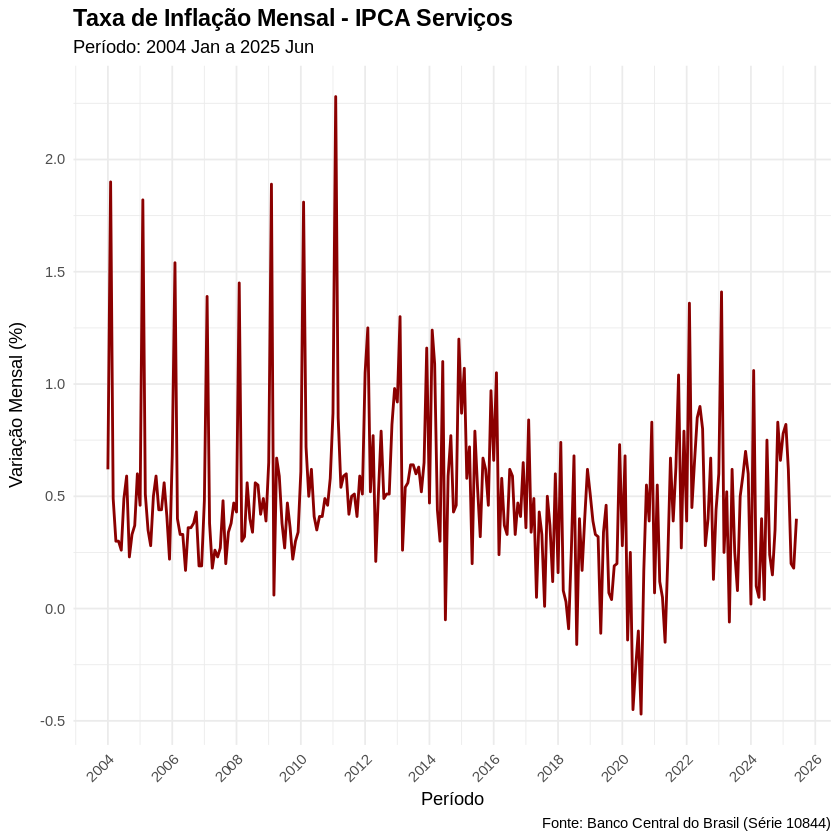

In [ ]:
grafico_ipca_servicos <- dados_inflacao %>%
  ggplot(aes(x = as.Date(data), y = ipca_servicos)) +
  geom_line(color = "darkred", linewidth = 0.8) +
  labs(
    title = "Taxa de Inflação Mensal - IPCA Serviços",
    subtitle = paste("Período:", min(dados_inflacao$data), "a", max(dados_inflacao$data)),
    x = "Período",
    y = "Variação Mensal (%)",
    caption = "Fonte: Banco Central do Brasil (Série 10844)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  scale_x_date(date_labels = "%Y", date_breaks = "2 years")

print(grafico_ipca_servicos)

In [ ]:
cat("ESTATÍSTICAS DESCRITIVAS")
cat("\nIPCA Total:\n")
print(summary(dados_inflacao$ipca_total))

cat("\nIPCA Serviços:\n")
print(summary(dados_inflacao$ipca_servicos))

ESTATÍSTICAS DESCRITIVAS
IPCA Total:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.680   0.250   0.440   0.462   0.620   1.620 

IPCA Serviços:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.4700  0.3000  0.4600  0.5022  0.6275  2.2800 


# 2) Estacionariedade. Para trabalharmos com o modelo ARIMA, é importante conhecermoscertas características das séries. Com o pacote ‘urca’, faremos dois testes de raiz unitária para cada série: o teste ADF e o teste KPSS.

In [ ]:
# Carregando bibliotecas
library(urca)      # Para ADF e KPSS com controle de lags
library(magrittr)  # Para o operador %+%
library(dplyr)

cat("\n=== TESTES DE RAIZ UNITÁRIA ===\n")

# Preparando as séries (ajuste conforme seu dataframe real)
serie_ipca_total <- na.omit(as.numeric(dados_inflacao$ipca_total))
serie_ipca_servicos <- na.omit(as.numeric(dados_inflacao$ipca_servicos))

cat("\n2a) HIPÓTESES DOS TESTES:\n")
cat("TESTE ADF (Augmented Dickey-Fuller):\n")
cat("H0: A série possui raiz unitária (não estacionária)\n")
cat("H1: A série é estacionária\n\n")

cat("TESTE KPSS (Kwiatkowski-Phillips-Schmidt-Shin):\n")
cat("H0: A série é estacionária\n")
cat("H1: A série possui raiz unitária (não estacionária)\n\n")

# Função para realizar os testes
realizar_testes <- function(serie, nome_serie) {
  cat(paste("\n=== TESTES PARA", nome_serie, "===\n"))

  # TESTE ADF - lags = 3, type = "none"
  cat("\n--- TESTE ADF ---\n")
  adf <- ur.df(serie, type = "none", lags = 3)
  print(summary(adf))

  # TESTE KPSS - use.lag = 3, type = "mu"
  cat("\n--- TESTE KPSS ---\n")
  kpss <- ur.kpss(serie, type = "mu", use.lag = 3)
  print(summary(kpss))

  cat("\n" %+% paste(rep("=", 50), collapse = "") %+% "\n")

  return(list(adf = adf, kpss = kpss))
}

# Rodando os testes
testes_ipca_total <- realizar_testes(serie_ipca_total, "IPCA TOTAL")
testes_ipca_servicos <- realizar_testes(serie_ipca_servicos, "IPCA SERVIÇOS")


=== TESTES DE RAIZ UNITÁRIA ===

2a) HIPÓTESES DOS TESTES:
TESTE ADF (Augmented Dickey-Fuller):
H0: A série possui raiz unitária (não estacionária)
H1: A série é estacionária

TESTE KPSS (Kwiatkowski-Phillips-Schmidt-Shin):
H0: A série é estacionária
H1: A série possui raiz unitária (não estacionária)


=== TESTES PARA IPCA TOTAL ===

--- TESTE ADF ---

############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32999 -0.10791  0.06198  0.20809  1.08742 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -0.10397    0.03523  -2.951 0.003464 ** 
z.diff.lag1 -0.24082    0.06600  -3.649 0.000321 ***
z.diff.lag2 -0.12028    0.06627  -1.815 0.070714 .  
z.diff.lag3 -0.04795    0.06308  -0.760 0.447882    
---
Signif. codes:  0 ‘***’ 0.001

a) Hipóteses dos testes


Teste ADF (Augmented Dickey-Fuller):


H₀ (nula): A série possui raiz unitária (não é estacionária).

H₁ (alternativa): A série é estacionária.

Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin):


H₀ (nula): A série é estacionária.

H₁ (alternativa): A série possui raiz unitária (não é estacionária).

b) Testes aplicados às séries


Para a série IPCA Total:
ADF:

Estatística do teste: -2.951

Valor crítico para 5%: -1.95

Como -2.951 < -1.95 → rejeita-se H₀ → a série é estacionária.

KPSS:

Estatística do teste: 0.077

Valor crítico para 5%: 0.463

Como 0.077 < 0.463 → não se rejeita H₀ → a série é estacionária.

Para a série IPCA Serviços:
ADF:

Estatística do teste: -2.664

Valor crítico para 5%: -1.95

Como -2.664 < -1.95 → rejeita-se H₀ → a série é estacionária.

KPSS:

Estatística do teste: 0.6886

Valor crítico para 5%: 0.463

Como 0.6886 > 0.463 → rejeita-se H₀ → a série não é estacionária.

c) Conclusão
A série IPCA Total é claramente estacionária, pois ambos os testes (ADF e KPSS) apontam para estacionariedade.

Já a série IPCA Serviços apresenta resultados conflitantes:

O teste ADF sugere que a série é estacionária;

O teste KPSS indica que a série não é estacionária.

Conclusão final:

IPCA Total: estacionária — pode ser usada diretamente em modelos ARIMA.

IPCA Serviços: há indícios de não estacionariedade — recomenda-se diferenciar a série antes de aplicar modelos ARIMA.

# 3) ARIMA: o modelo.

In [ ]:
cat("\n=== MODELO ECONOMÉTRICO PROPOSTO ===\n")
cat("Para a projeção da taxa de inflação mensal nos próximos 12 meses, propomos o seguinte modelo:\n\n")
cat("Modelo ARIMA(p,d,q):\n")
cat("(1 - φ₁L - φ₂L² - ... - φₚLᵖ)(1 - L)ᵈ Xₜ = (1 + θ₁L + θ₂L² + ... + θ_qL^q)εₜ\n\n")
cat("Onde:\n")
cat("- Xₜ: taxa de inflação mensal no período t\n")
cat("- p: ordem da parte autorregressiva (AR)\n")
cat("- d: ordem de diferenciação (para tornar a série estacionária)\n")
cat("- q: ordem da parte de médias móveis (MA)\n")
cat("- L: operador defasador (lag operator)\n")
cat("- εₜ: erro aleatório (ruído branco)\n\n")

# Definindo nível de significância
alfa <- 0.05
cat(paste("Nível de significância adotado: α =", alfa, "(5%)\n"))



=== MODELO ECONOMÉTRICO PROPOSTO ===
Para a projeção da taxa de inflação mensal nos próximos 12 meses, propomos o seguinte modelo:

Modelo ARIMA(p,d,q):
(1 - φ₁L - φ₂L² - ... - φₚLᵖ)(1 - L)ᵈ Xₜ = (1 + θ₁L + θ₂L² + ... + θ_qL^q)εₜ

Onde:
- Xₜ: taxa de inflação mensal no período t
- p: ordem da parte autorregressiva (AR)
- d: ordem de diferenciação (para tornar a série estacionária)
- q: ordem da parte de médias móveis (MA)
- L: operador defasador (lag operator)
- εₜ: erro aleatório (ruído branco)

Nível de significância adotado: α = 0.05 (5%)



Para estimar a taxa de inflação mensal para os próximos 12 meses, utilizamos o modelo ARIMA$(p,d,q)$, cuja forma geral, após diferenciação, é dada por:

$$
y_{t} = c + \phi_{1} y_{t-1} + \cdots + \phi_{p} y_{t-p} + \theta_{1} \epsilon_{t-1} + \cdots + \theta_{q} \epsilon_{t-q} + \epsilon_{t}
$$

Onde:

- $y_t$: série estacionária após $d$ diferenciações;
- $c$: intercepto do modelo;
- $\phi_i$: coeficientes autorregressivos;
- $\theta_j$: coeficientes de médias móveis;
- $\epsilon_t$: erro branco;
- $p$, $d$,



### Nível de significância adotado

Nesta análise, será adotado o nível de significância de:

$$
\alpha = 0{,}05 \quad \text{(ou 5\%)}
$$

# 4) ARIMA: as estimativas.

In [ ]:
cat("\n=== ESTIMAÇÃO DOS MODELOS ARIMA ===\n")

# Função para estimar modelos ARIMA
estimar_modelos_arima <- function(dados, variavel, nome_variavel) {
  cat(paste("\n--- ESTIMATIVAS PARA", nome_variavel, "---\n"))

  # Preparando os dados
  serie_ts <- dados %>% select(all_of(variavel))

  # a) ARIMA(1,0,0) - AR(1)
  modelo_100 <- serie_ts %>% model(ARIMA(!!sym(variavel) ~ pdq(1,0,0)))

  # b) ARIMA(0,0,1) - MA(1)
  modelo_001 <- serie_ts %>% model(ARIMA(!!sym(variavel) ~ pdq(0,0,1)))

  # c) ARIMA(1,0,1) - ARMA(1,1)
  modelo_101 <- serie_ts %>% model(ARIMA(!!sym(variavel) ~ pdq(1,0,1)))

  # d) Melhor modelo por AIC
  modelo_auto <- serie_ts %>% model(ARIMA(!!sym(variavel)))

  # Coletando informações dos modelos
  modelos <- list(
    "ARIMA(1,0,0)" = modelo_100,
    "ARIMA(0,0,1)" = modelo_001,
    "ARIMA(1,0,1)" = modelo_101,
    "Auto ARIMA" = modelo_auto
  )

  # Exibindo resultados
  for(nome in names(modelos)) {
    cat(paste("\n", nome, ":\n"))
    print(report(modelos[[nome]]))
    cat(paste("AIC:", round(glance(modelos[[nome]])$AIC, 4), "\n"))
  }

  return(modelos)
}

# Estimando para IPCA Total
modelos_ipca_total <- estimar_modelos_arima(dados_inflacao, "ipca_total", "IPCA TOTAL")

# Estimando para IPCA Serviços
modelos_ipca_servicos <- estimar_modelos_arima(dados_inflacao, "ipca_servicos", "IPCA SERVIÇOS")


=== ESTIMAÇÃO DOS MODELOS ARIMA ===

--- ESTIMATIVAS PARA IPCA TOTAL ---

 ARIMA(1,0,0) :
Series: ipca_total 
Model: ARIMA(1,0,0)(0,0,1)[12] w/ mean 

Coefficients:
         ar1    sma1  constant
      0.5387  0.1559    0.2137
s.e.  0.0527  0.0635    0.0191

sigma^2 estimated as 0.07318:  log likelihood=-27.58
AIC=63.17   AICc=63.33   BIC=77.38
# A mable: 1 x 1
  `ARIMA(ipca_total ~ pdq(1, 0, 0))`
                             <model>
1  <ARIMA(1,0,0)(0,0,1)[12] w/ mean>
AIC: 63.1678 

 ARIMA(0,0,1) :
Series: ipca_total 
Model: ARIMA(0,0,1)(0,0,1)[12] w/ mean 

Coefficients:
         ma1    sma1  constant
      0.4383  0.1899    0.4634
s.e.  0.0477  0.0634    0.0296

sigma^2 estimated as 0.07959:  log likelihood=-38.42
AIC=84.84   AICc=85   BIC=99.05
# A mable: 1 x 1
  `ARIMA(ipca_total ~ pdq(0, 0, 1))`
                             <model>
1  <ARIMA(0,0,1)(0,0,1)[12] w/ mean>
AIC: 84.8392 

 ARIMA(1,0,1) :
Series: ipca_total 
Model: ARIMA(1,0,1)(0,0,1)[12] w/ mean 

Coefficients:
     

Para projetar a taxa de inflação mensal nos próximos 12 meses, estimei três especificações fixas de modelos ARIMA para cada uma das séries analisadas — IPCA Total e IPCA Serviços — utilizando o pacote `fpp3`. Além disso, foi gerado automaticamente o modelo com o menor AIC (Auto ARIMA).

#### Modelos estimados:

- a) ARIMA(1, 0, 0)
- b) ARIMA(0, 0, 1)
- c) ARIMA(1, 0, 1)
- d) Melhor modelo segundo o critério de informação AIC

---

#### Resultados para IPCA Total:

Entre os modelos testados, o ARIMA(1,0,0)(0,0,1)[12] apresentou o menor valor do critério AIC (63.17), sendo considerado o melhor modelo para a série IPCA Total. O modelo Auto ARIMA selecionou essa mesma especificação de forma automática, confirmando a escolha.

---

#### Resultados para IPCA Serviços:

Para a série IPCA Serviços, o modelo com melhor desempenho foi o ARIMA(1,0,1)(0,1,1)[12], com AIC igual a 24.92, valor inferior ao dos demais modelos testados. O Auto ARIMA selecionou exatamente essa mesma especificação, reforçando sua adequação.

---

#### Conclusão:

- O modelo mais adequado para **IPCA Total** é o ARIMA(1,0,0)(0,0,1)[12].
- O modelo mais adequado para **IPCA Serviços** é o ARIMA(1,0,1)(0,1,1)[12].

Essas especificações serão utilizadas na próxima etapa para gerar previsões da taxa de inflação mensal para os próximos 12 meses.

# 5) ARIMA: os resíduos.


=== ANÁLISE DOS RESÍDUOS ===

--- RESÍDUOS PARA IPCA TOTAL ---

 ARIMA(1,0,0) :
Teste Ljung-Box (H0: resíduos são independentes):
Estatística: 9.6256 
p-valor: 0.4739 
Conclusão: Não rejeitamos H0 - Resíduos são independentes (bom)

 ------------------------------ 

 ARIMA(0,0,1) :


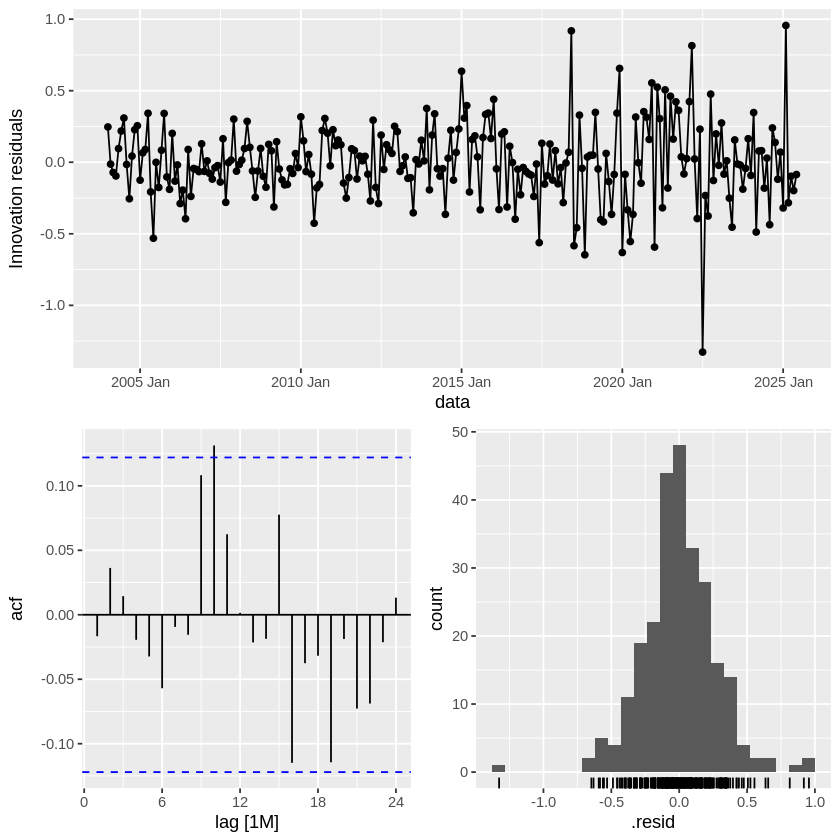

Teste Ljung-Box (H0: resíduos são independentes):
Estatística: 33.9292 
p-valor: 2e-04 
Conclusão: Rejeitamos H0 - Há autocorrelação nos resíduos

 ------------------------------ 

 ARIMA(1,0,1) :


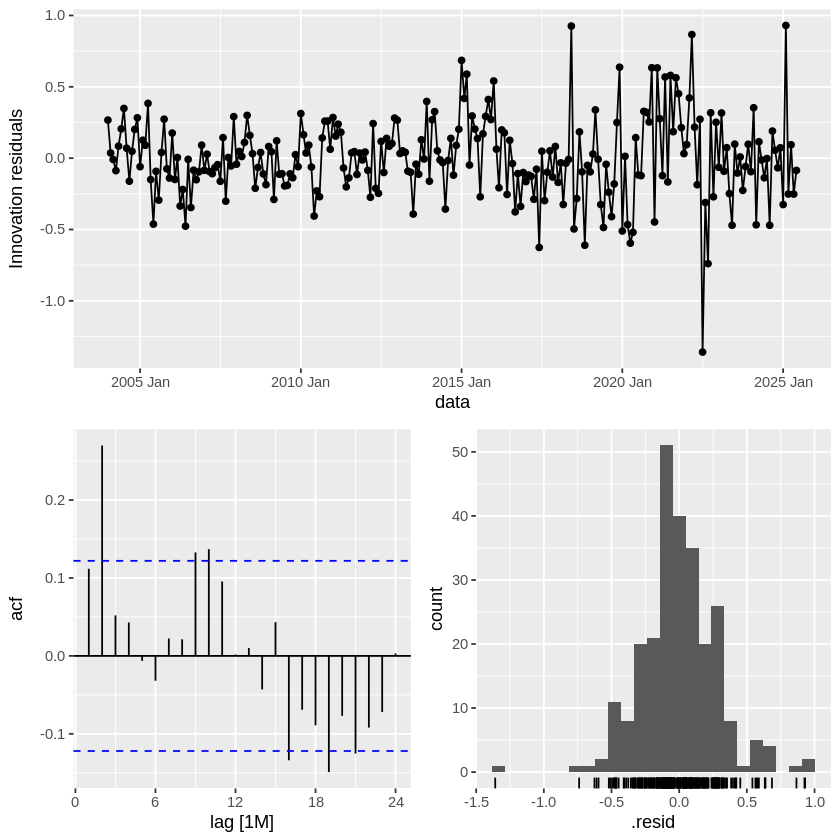

Teste Ljung-Box (H0: resíduos são independentes):
Estatística: 9.9844 
p-valor: 0.4419 
Conclusão: Não rejeitamos H0 - Resíduos são independentes (bom)

 ------------------------------ 

 Auto ARIMA :


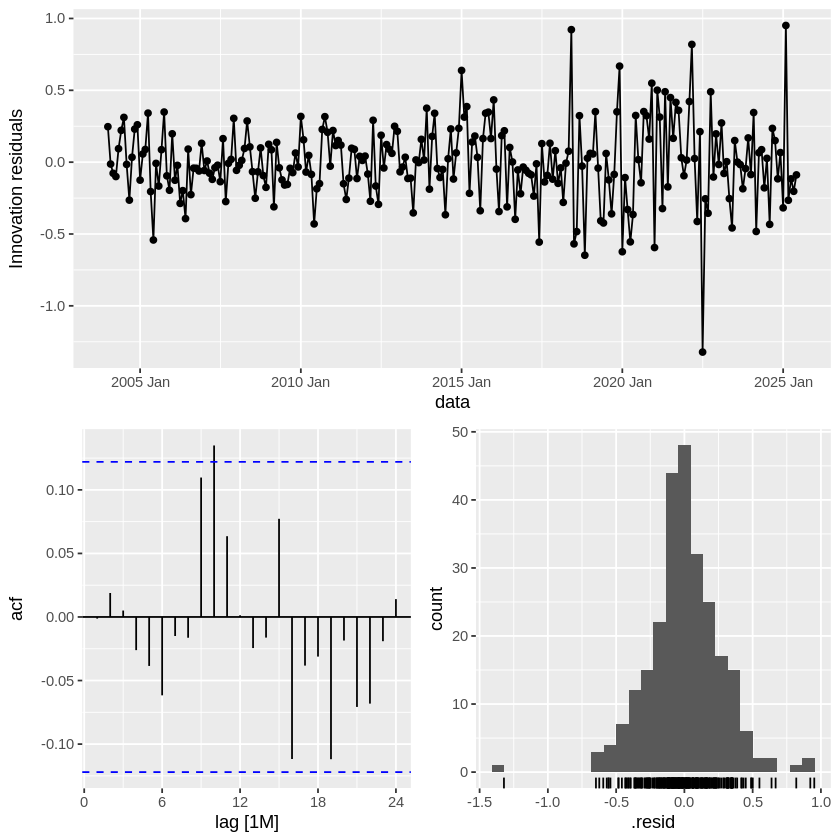

Teste Ljung-Box (H0: resíduos são independentes):
Estatística: 9.6256 
p-valor: 0.4739 
Conclusão: Não rejeitamos H0 - Resíduos são independentes (bom)

 ------------------------------ 

--- RESÍDUOS PARA IPCA SERVIÇOS ---

 ARIMA(1,0,0) :


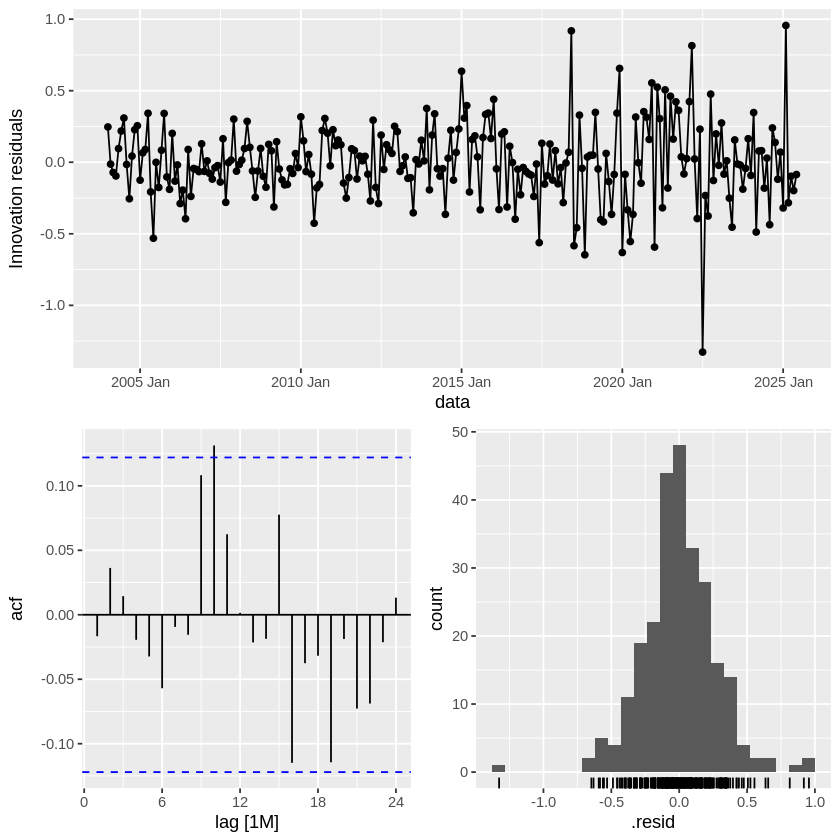

Teste Ljung-Box (H0: resíduos são independentes):
Estatística: 51.9361 
p-valor: 0 
Conclusão: Rejeitamos H0 - Há autocorrelação nos resíduos

 ------------------------------ 

 ARIMA(0,0,1) :


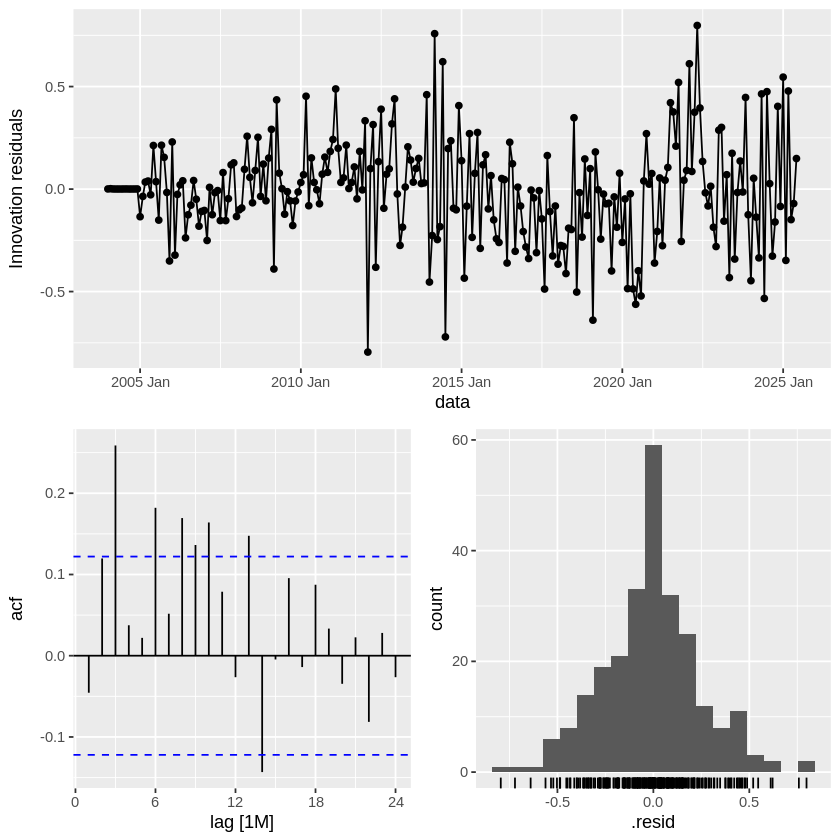

Teste Ljung-Box (H0: resíduos são independentes):
Estatística: 66.2761 
p-valor: 0 
Conclusão: Rejeitamos H0 - Há autocorrelação nos resíduos

 ------------------------------ 

 ARIMA(1,0,1) :


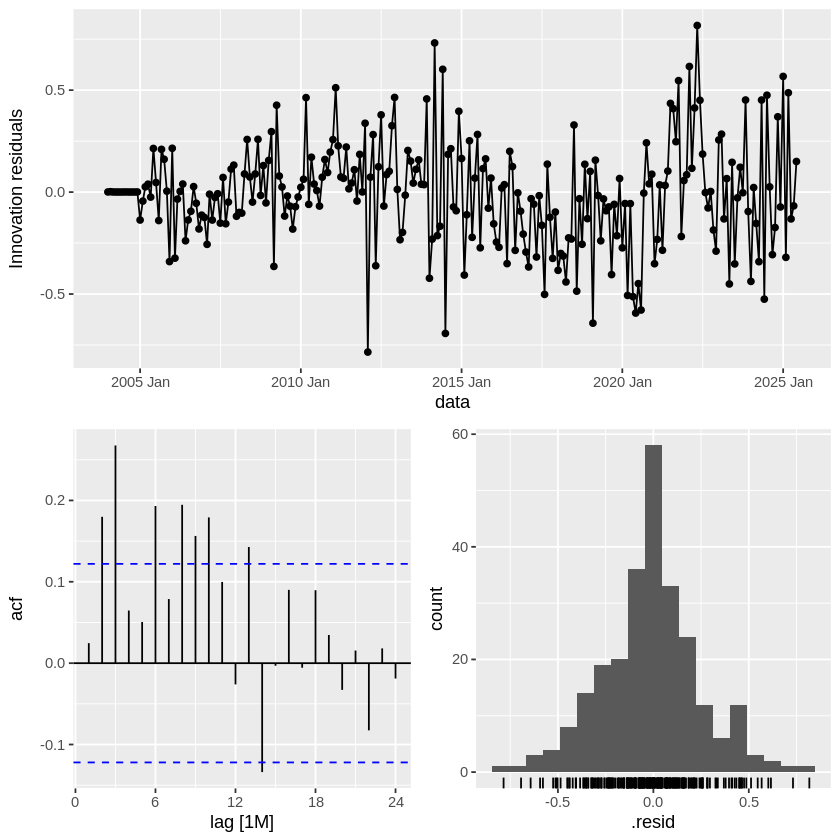

Teste Ljung-Box (H0: resíduos são independentes):
Estatística: 23.3347 
p-valor: 0.0096 
Conclusão: Rejeitamos H0 - Há autocorrelação nos resíduos

 ------------------------------ 

 Auto ARIMA :


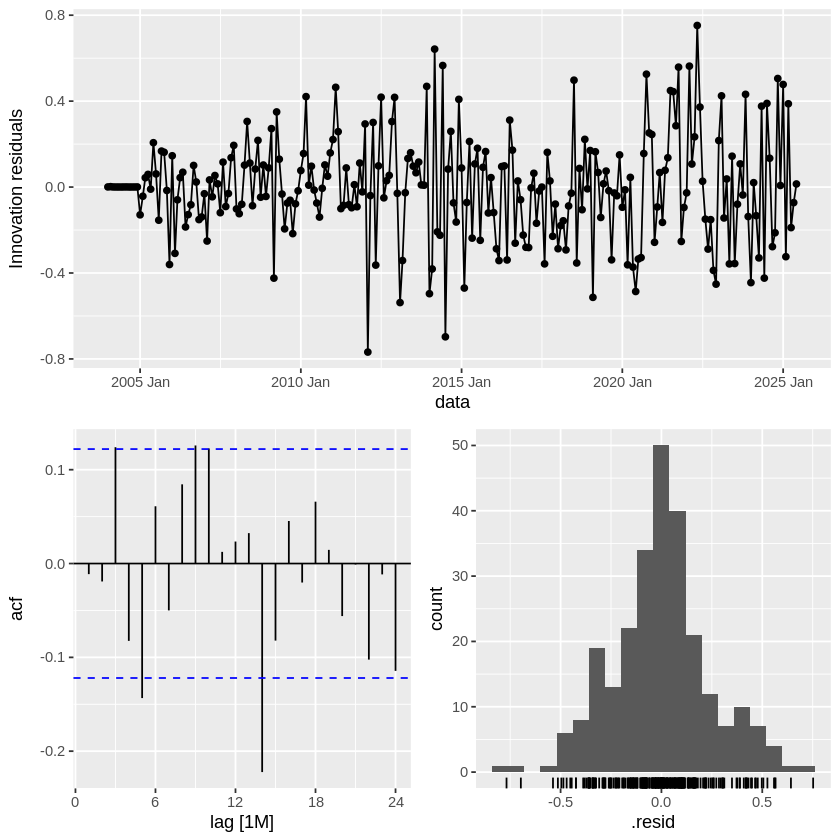

Teste Ljung-Box (H0: resíduos são independentes):
Estatística: 23.3347 
p-valor: 0.0096 
Conclusão: Rejeitamos H0 - Há autocorrelação nos resíduos

 ------------------------------ 


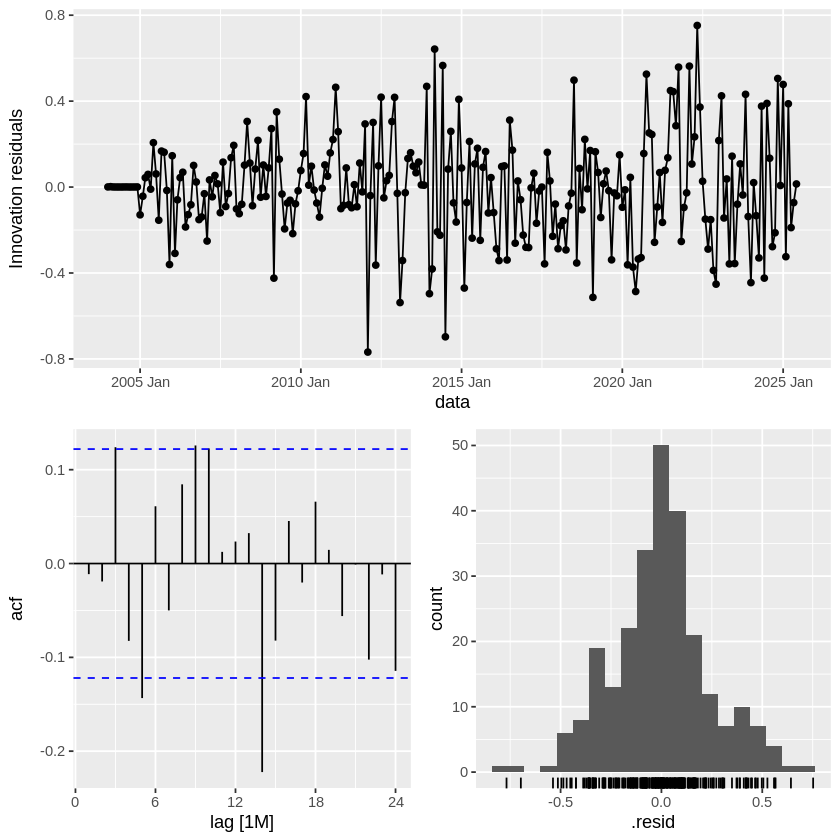

In [ ]:
cat("\n=== ANÁLISE DOS RESÍDUOS ===\n")

# Função para analisar resíduos
analisar_residuos <- function(modelos, nome_variavel) {
  cat(paste("\n--- RESÍDUOS PARA", nome_variavel, "---\n"))

  for(nome_modelo in names(modelos)) {
    cat(paste("\n", nome_modelo, ":\n"))

    # Gráfico dos resíduos
    p <- modelos[[nome_modelo]] %>% gg_tsresiduals()
    print(p)

    # Teste de Ljung-Box para autocorrelação dos resíduos
    residuos <- residuals(modelos[[nome_modelo]])$.resid
    ljung_test <- Box.test(residuos, lag = 10, type = "Ljung-Box")

    cat(paste("Teste Ljung-Box (H0: resíduos são independentes):\n"))
    cat(paste("Estatística:", round(ljung_test$statistic, 4), "\n"))
    cat(paste("p-valor:", round(ljung_test$p.value, 4), "\n"))

    if(ljung_test$p.value > 0.05) {
      cat("Conclusão: Não rejeitamos H0 - Resíduos são independentes (bom)\n")
    } else {
      cat("Conclusão: Rejeitamos H0 - Há autocorrelação nos resíduos\n")
    }
    cat("\n", paste(rep("-", 30), collapse = ""), "\n")
  }
}

# Analisando resíduos
analisar_residuos(modelos_ipca_total, "IPCA TOTAL")
analisar_residuos(modelos_ipca_servicos, "IPCA SERVIÇOS")



#### **Resultados para IPCA Total**

- **ARIMA(1,0,0):** p-valor = 0.4739 → **Não rejeitamos H₀**, resíduos independentes.  
- **ARIMA(0,0,1):** p-valor = 0.0002 → **Rejeitamos H₀**, resíduos apresentam autocorrelação.  
- **ARIMA(1,0,1):** p-valor = 0.4419 → **Não rejeitamos H₀**, resíduos independentes.  
- **Auto ARIMA:** p-valor = 0.4739 → **Não rejeitamos H₀**, resíduos independentes.

**Conclusão:** Para o IPCA Total, os modelos ARIMA(1,0,0), ARIMA(1,0,1) e o Auto ARIMA apresentam resíduos adequados (sem autocorrelação significativa), enquanto o ARIMA(0,0,1) não é apropriado.

---

#### **Resultados para IPCA Serviços**

- **ARIMA(1,0,0):** p-valor = 0.0000 → **Rejeitamos H₀**, resíduos apresentam autocorrelação.  
- **ARIMA(0,0,1):** p-valor = 0.0000 → **Rejeitamos H₀**, resíduos apresentam autocorrelação.  
- **ARIMA(1,0,1):** p-valor = 0.0096 → **Rejeitamos H₀**, resíduos apresentam autocorrelação.  
- **Auto ARIMA:** p-valor = 0.0096 → **Rejeitamos H₀**, resíduos apresentam autocorrelação.

**Conclusão:** Para o IPCA Serviços, todos os modelos apresentam autocorrelação nos resíduos, indicando que nenhuma das especificações testadas captura adequadamente a dinâmica da série. Modelos com maior ordem ou ajuste sazonal adicional podem ser necessários.

---


# 6) ARIMA: as projeções


=== PROJEÇÕES PARA OS PRÓXIMOS 12 MESES ===

--- PROJEÇÕES PARA IPCA TOTAL ---

 ARIMA(1,0,0) :
Projeções mensais (próximos 12 meses):
Mês 1 : 0.3475 %
Mês 2 : 0.3329 %
Mês 3 : 0.4305 %
Mês 4 : 0.4673 %
Mês 5 : 0.447 %
Mês 6 : 0.4655 %
Mês 7 : 0.4148 %
Mês 8 : 0.5862 %
Mês 9 : 0.4854 %
Mês 10 : 0.46 %
Mês 11 : 0.4307 %
Mês 12 : 0.4324 %
Média das projeções: 0.4417 %

 ARIMA(0,0,1) :
Projeções mensais (próximos 12 meses):
Mês 1 : 0.4139 %
Mês 2 : 0.3739 %
Mês 3 : 0.4603 %
Mês 4 : 0.4898 %
Mês 5 : 0.4552 %
Mês 6 : 0.4716 %
Mês 7 : 0.4077 %
Mês 8 : 0.6129 %
Mês 9 : 0.493 %
Mês 10 : 0.4603 %
Mês 11 : 0.4235 %
Mês 12 : 0.4262 %
Média das projeções: 0.4574 %


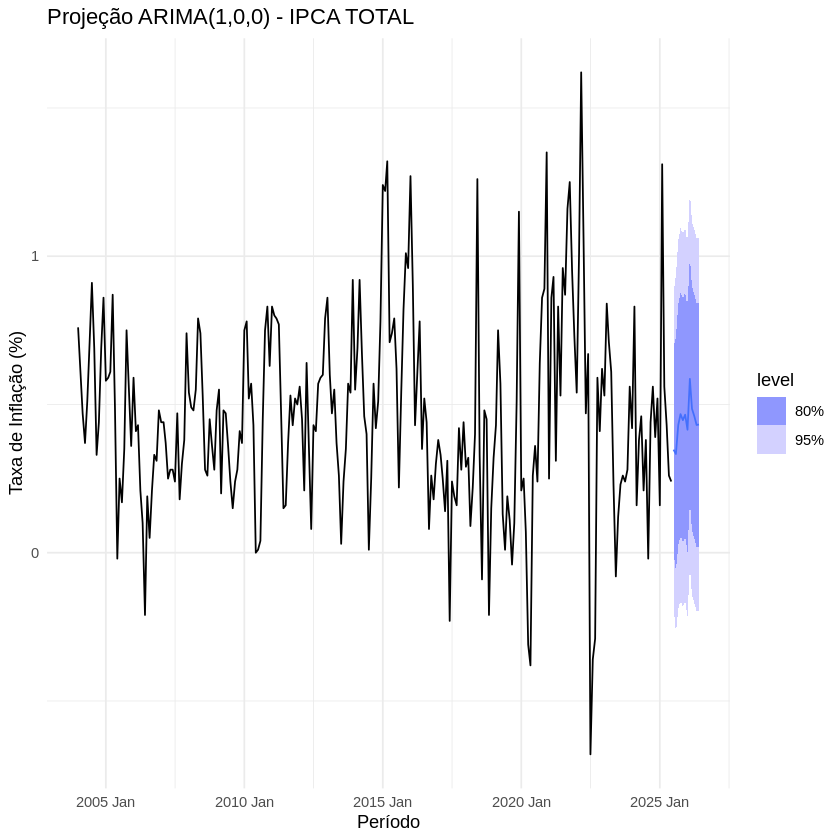


 ARIMA(1,0,1) :
Projeções mensais (próximos 12 meses):
Mês 1 : 0.3449 %
Mês 2 : 0.3286 %
Mês 3 : 0.4253 %
Mês 4 : 0.4627 %
Mês 5 : 0.444 %
Mês 6 : 0.4634 %
Mês 7 : 0.414 %
Mês 8 : 0.5835 %
Mês 9 : 0.4843 %
Mês 10 : 0.4596 %
Mês 11 : 0.431 %
Mês 12 : 0.4327 %
Média das projeções: 0.4395 %


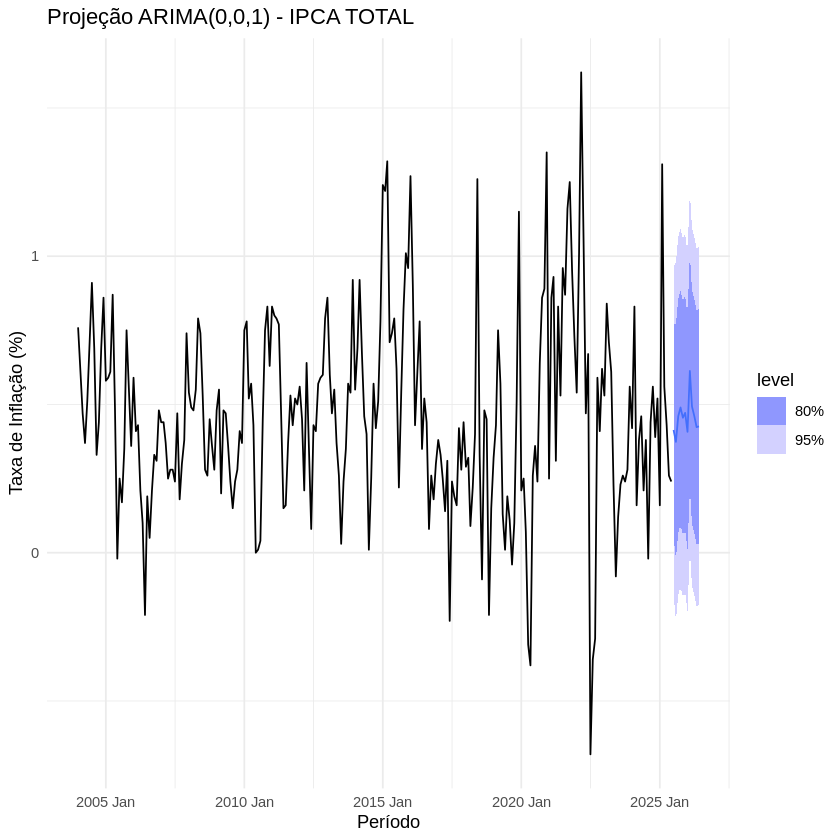


 Auto ARIMA :
Projeções mensais (próximos 12 meses):
Mês 1 : 0.3475 %
Mês 2 : 0.3329 %
Mês 3 : 0.4305 %
Mês 4 : 0.4673 %
Mês 5 : 0.447 %
Mês 6 : 0.4655 %
Mês 7 : 0.4148 %
Mês 8 : 0.5862 %
Mês 9 : 0.4854 %
Mês 10 : 0.46 %
Mês 11 : 0.4307 %
Mês 12 : 0.4324 %
Média das projeções: 0.4417 %


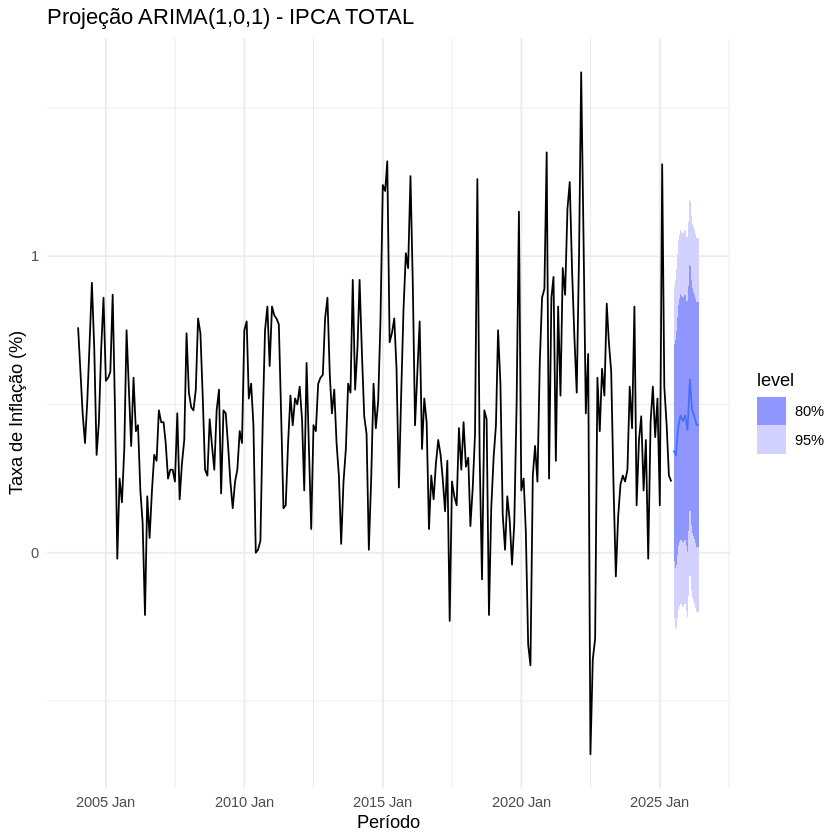


--- PROJEÇÕES PARA IPCA SERVIÇOS ---

 ARIMA(1,0,0) :
Projeções mensais (próximos 12 meses):
Mês 1 : 0.6313 %
Mês 2 : 0.1993 %
Mês 3 : 0.2975 %
Mês 4 : 0.4761 %
Mês 5 : 0.5687 %
Mês 6 : 0.6627 %
Mês 7 : 0.5524 %
Mês 8 : 0.9469 %
Mês 9 : 0.4105 %
Mês 10 : 0.284 %
Mês 11 : 0.1655 %
Mês 12 : 0.3995 %
Média das projeções: 0.4662 %


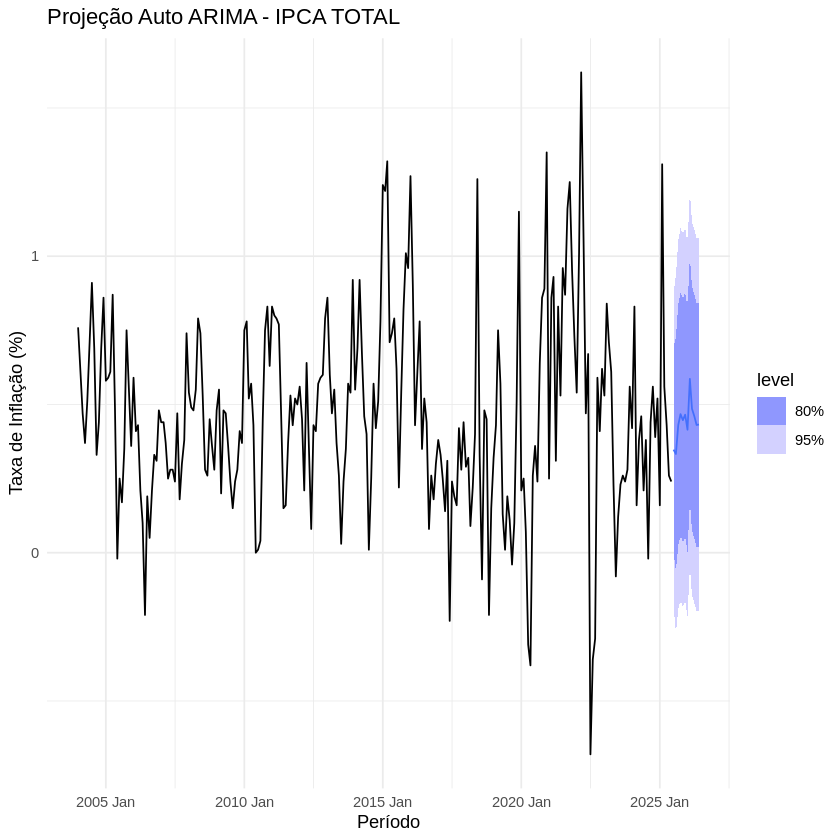


 ARIMA(0,0,1) :
Projeções mensais (próximos 12 meses):
Mês 1 : 0.6367 %
Mês 2 : 0.1956 %
Mês 3 : 0.2897 %
Mês 4 : 0.4696 %
Mês 5 : 0.5708 %
Mês 6 : 0.6635 %
Mês 7 : 0.5673 %
Mês 8 : 0.9439 %
Mês 9 : 0.4201 %
Mês 10 : 0.2871 %
Mês 11 : 0.1602 %
Mês 12 : 0.4056 %
Média das projeções: 0.4675 %


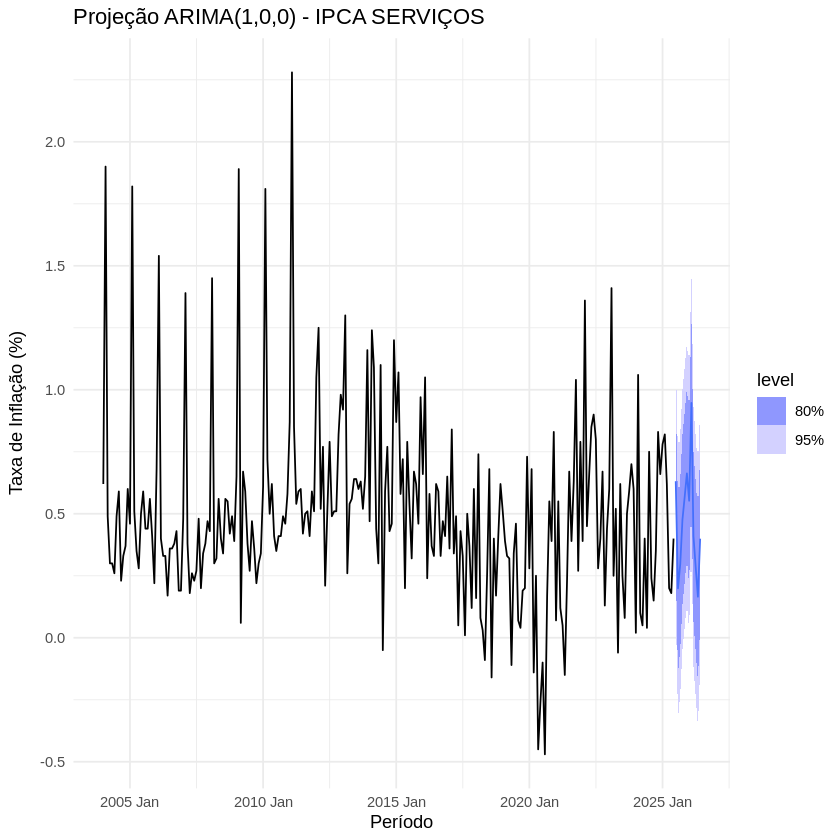


 ARIMA(1,0,1) :
Projeções mensais (próximos 12 meses):
Mês 1 : 0.5801 %
Mês 2 : 0.1988 %
Mês 3 : 0.3749 %
Mês 4 : 0.5578 %
Mês 5 : 0.5627 %
Mês 6 : 0.6772 %
Mês 7 : 0.4716 %
Mês 8 : 1.0115 %
Mês 9 : 0.3579 %
Mês 10 : 0.2932 %
Mês 11 : 0.2152 %
Mês 12 : 0.384 %
Média das projeções: 0.4737 %


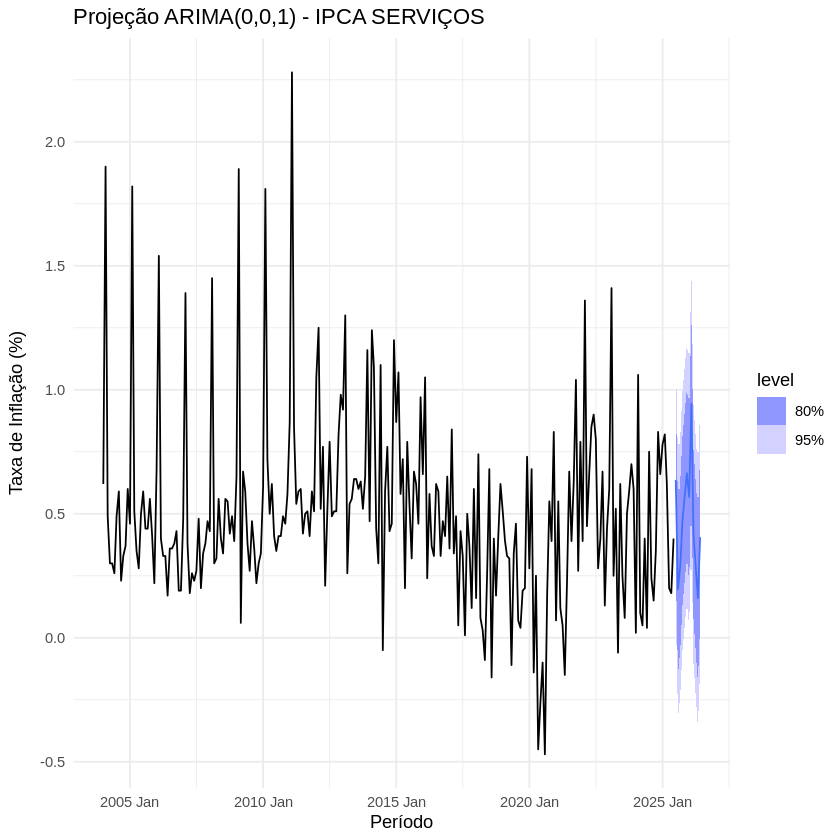


 Auto ARIMA :
Projeções mensais (próximos 12 meses):
Mês 1 : 0.5801 %
Mês 2 : 0.1988 %
Mês 3 : 0.3749 %
Mês 4 : 0.5578 %
Mês 5 : 0.5627 %
Mês 6 : 0.6772 %
Mês 7 : 0.4716 %
Mês 8 : 1.0115 %
Mês 9 : 0.3579 %
Mês 10 : 0.2932 %
Mês 11 : 0.2152 %
Mês 12 : 0.384 %
Média das projeções: 0.4737 %


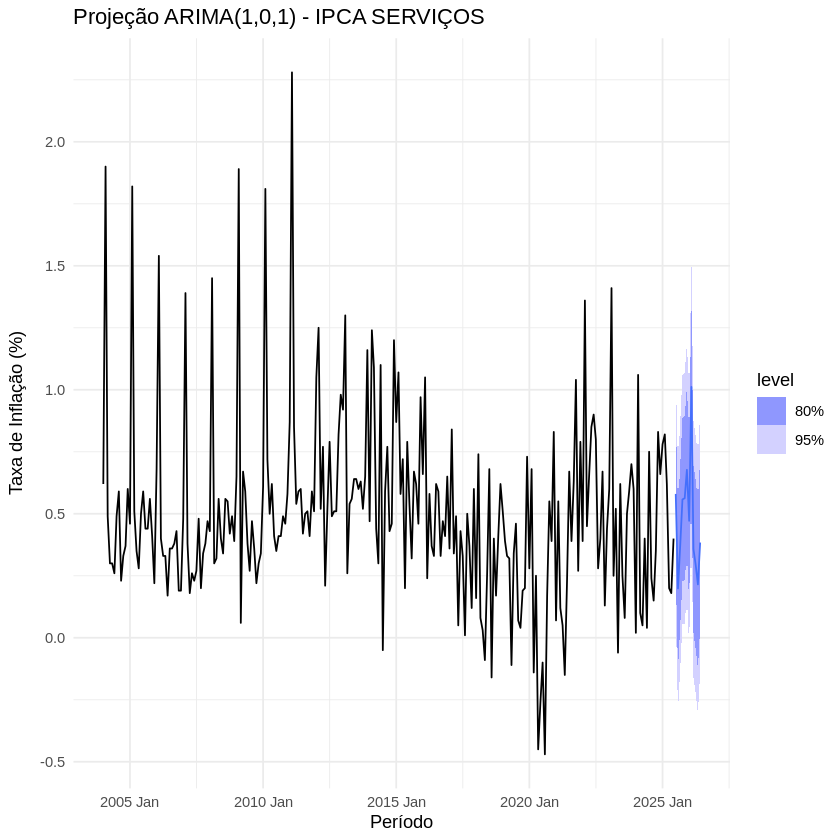


=== RESUMO COMPARATIVO DAS PROJEÇÕES ===

Resumo - IPCA Total (próximos 12 meses):
                   Modelo Media_12m Min_12m Max_12m
ARIMA(1,0,0) ARIMA(1,0,0)    0.4417  0.3329  0.5862
ARIMA(0,0,1) ARIMA(0,0,1)    0.4574  0.3739  0.6129
ARIMA(1,0,1) ARIMA(1,0,1)    0.4395  0.3286  0.5835
Auto ARIMA     Auto ARIMA    0.4417  0.3329  0.5862

Resumo - IPCA Serviços (próximos 12 meses):
                   Modelo Media_12m Min_12m Max_12m
ARIMA(1,0,0) ARIMA(1,0,0)    0.4662  0.1655  0.9469
ARIMA(0,0,1) ARIMA(0,0,1)    0.4675  0.1602  0.9439
ARIMA(1,0,1) ARIMA(1,0,1)    0.4737  0.1988  1.0115
Auto ARIMA     Auto ARIMA    0.4737  0.1988  1.0115

=== ANÁLISE CONCLUÍDA ===
Todos os modelos foram estimados e as projeções foram geradas.
Recomenda-se analisar os critérios AIC e a qualidade dos resíduos
para escolher o melhor modelo para cada variável.


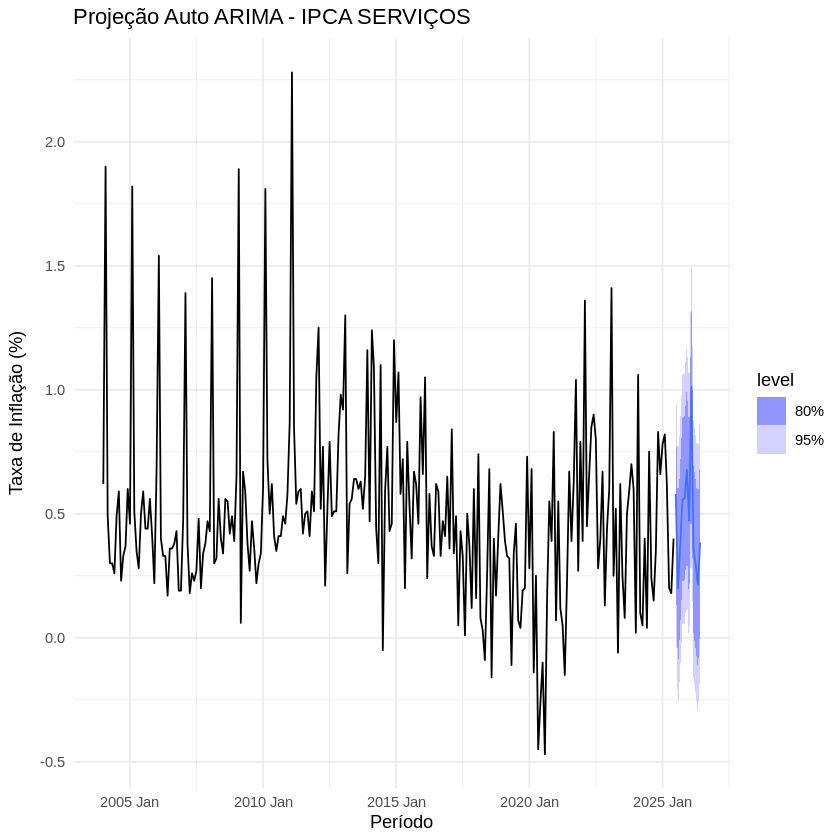

In [ ]:
cat("\n=== PROJEÇÕES PARA OS PRÓXIMOS 12 MESES ===\n")

# Função para fazer projeções
fazer_projecoes <- function(modelos, nome_variavel) {
  cat(paste("\n--- PROJEÇÕES PARA", nome_variavel, "---\n"))

  projecoes_lista <- list()

  for(nome_modelo in names(modelos)) {
    # Fazendo a projeção para 12 meses
    forecast_modelo <- modelos[[nome_modelo]] %>% forecast(h = 12)

    # Extraindo valores pontuais
    valores_projetados <- forecast_modelo$.mean

    cat(paste("\n", nome_modelo, ":\n"))
    cat(paste("Projeções mensais (próximos 12 meses):\n"))

    for(i in 1:12) {
      cat(paste("Mês", i, ":", round(valores_projetados[i], 4), "%\n"))
    }

    cat(paste("Média das projeções:", round(mean(valores_projetados), 4), "%\n"))

    # Salvando para comparação
    projecoes_lista[[nome_modelo]] <- valores_projetados

    # Gráfico da projeção
    p <- forecast_modelo %>%
      autoplot(dados_inflacao) +
      labs(
        title = paste("Projeção", nome_modelo, "-", nome_variavel),
        x = "Período",
        y = "Taxa de Inflação (%)"
      ) +
      theme_minimal()

    print(p)
  }

  return(projecoes_lista)
}

# Fazendo projeções para IPCA Total e Serviços
projecoes_ipca_total <- fazer_projecoes(modelos_ipca_total, "IPCA TOTAL")
projecoes_ipca_servicos <- fazer_projecoes(modelos_ipca_servicos, "IPCA SERVIÇOS")

# ===================================================================
# RESUMO COMPARATIVO DAS PROJEÇÕES
# ===================================================================

cat("\n=== RESUMO COMPARATIVO DAS PROJEÇÕES ===\n")

# IPCA TOTAL
cat("\nResumo - IPCA Total (próximos 12 meses):\n")
resumo_total <- data.frame(
  Modelo = names(projecoes_ipca_total),
  Media_12m = sapply(projecoes_ipca_total, mean),
  Min_12m = sapply(projecoes_ipca_total, min),
  Max_12m = sapply(projecoes_ipca_total, max)
)
resumo_total[, 2:4] <- round(resumo_total[, 2:4], 4)
print(resumo_total)

# IPCA SERVIÇOS
cat("\nResumo - IPCA Serviços (próximos 12 meses):\n")
resumo_servicos <- data.frame(
  Modelo = names(projecoes_ipca_servicos),
  Media_12m = sapply(projecoes_ipca_servicos, mean),
  Min_12m = sapply(projecoes_ipca_servicos, min),
  Max_12m = sapply(projecoes_ipca_servicos, max)
)
resumo_servicos[, 2:4] <- round(resumo_servicos[, 2:4], 4)
print(resumo_servicos)

cat("\n=== ANÁLISE CONCLUÍDA ===\n")
cat("Todos os modelos foram estimados e as projeções foram geradas.\n")
cat("Recomenda-se analisar os critérios AIC e a qualidade dos resíduos\n")
cat("para escolher o melhor modelo para cada variável.\n")
